In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

df = pd.read_csv(r"C:\Users\lakum\OneDrive\Desktop\rohith\train.csv")


diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

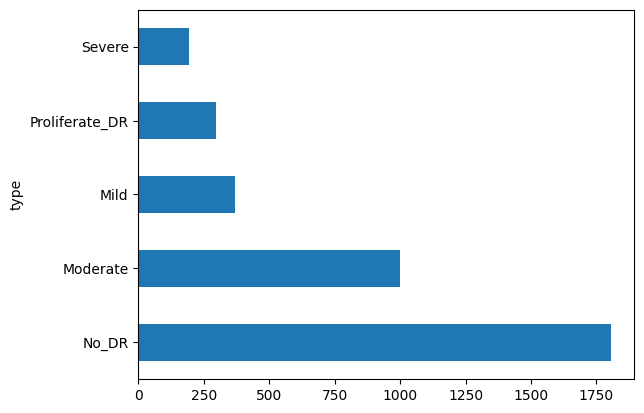

In [4]:
df['type'].value_counts().plot(kind='barh')

In [5]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [6]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [7]:
src_dir = r'C:\Users\lakum\OneDrive\Desktop\rohith\gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [9]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=5,
                    validation_data=val_batches)

Epoch 1/5



81/81 [==============================] - 54s 623ms/step - loss: 0.2828 - acc: 0.9071 - val_loss: 0.8371 - val_acc: 0.5073
Epoch 2/5
81/81 [==============================] - 18s 221ms/step - loss: 0.1622 - acc: 0.9399 - val_loss: 0.6046 - val_acc: 0.5382
Epoch 3/5
81/81 [==============================] - 17s 215ms/step - loss: 0.1124 - acc: 0.9614 - val_loss: 0.5648 - val_acc: 0.7127
Epoch 4/5
81/81 [==============================] - 17s 214ms/step - loss: 0.0850 - acc: 0.9731 - val_loss: 0.4716 - val_acc: 0.7164
Epoch 5/5
81/81 [==============================] - 18s 219ms/step - loss: 0.0530 - acc: 0.9824 - val_loss: 0.3009 - val_acc: 0.9073


In [10]:

# Assuming you have a TensorFlow model named 'model'
model_json = model.to_json()

# Save the model architecture in JSON format
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
weights = [np.array(w) for w in model.get_weights()]

# Save weights to a binary file
with open("model_weights.bin", "wb") as binary_file:
    for weight in weights:
        binary_file.write(weight.tobytes())


In [11]:
# Load Json
# Load the model architecture from the JSON file
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load the weights into the model
with open("model_weights.bin", "rb") as bin_file:
    for layer in loaded_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            # For BatchNormalization layers, load gamma and beta
            gamma_beta = np.fromfile(bin_file, dtype=np.float32, count=2 * layer.input_shape[-1])
            gamma = gamma_beta[:layer.input_shape[-1]]
            beta = gamma_beta[layer.input_shape[-1]:]
            moving_mean = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])
            moving_variance = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])

            layer.set_weights([gamma, beta, moving_mean, moving_variance])
        else:
            # For other layers, load weights as usual
            layer_weights = [np.fromfile(bin_file, dtype=np.float32, count=np.prod(param.shape)).reshape(param.shape)
                             for param in layer.trainable_variables]
            layer.set_weights(layer_weights)

In [12]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
print("Original: -\n")
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("Loaded: -\n")
loss, acc = loaded_model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

C:\Users\lakum\AppData\Local\Temp/ipykernel_19172/3250738270.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


Original: -

18/18 [==============================] - 6s 363ms/step - loss: 0.3119 - acc: 0.8945
Loss:  0.311924010515213
Accuracy:  0.8945454359054565
Loaded: -



C:\Users\lakum\AppData\Local\Temp/ipykernel_19172/3250738270.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = loaded_model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 3s 123ms/step - loss: 0.3119 - acc: 0.8945
Loss:  0.311924010515213
Accuracy:  0.8945454359054565


In [22]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
#     new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=loaded_model.predict(np.array([image]))
    print(predict)
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')

1/1 [==============================] - 0s 42ms/step
[[9.999902e-01 9.723469e-06]]
Diabetic Retinopathy Detected


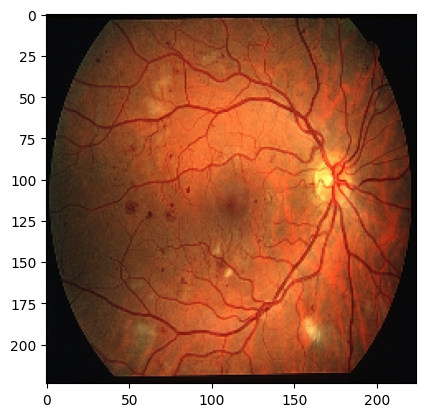

In [25]:
predict_class(r"C:\Users\lakum\Downloads\Test\npdr.jpg")
